In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

#Source
#Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link]
# Any results you write to the current directory are saved as output.

['drugLibTrain_raw.csv', 'drugLibTest_raw.csv']


# Import the libraries


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


%matplotlib inline

# Read in data

In [4]:
Test_df = pd.read_csv('../input/drugLibTest_raw.csv')
Train_df = pd.read_csv('../input/drugLibTrain_raw.csv')
Data_df = pd.concat([Train_df, Test_df])

Data_df.dropna(inplace = True)

Data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4132 entries, 0 to 1035
Data columns (total 9 columns):
Unnamed: 0           4132 non-null int64
urlDrugName          4132 non-null object
rating               4132 non-null int64
effectiveness        4132 non-null object
sideEffects          4132 non-null object
condition            4132 non-null object
benefitsReview       4132 non-null object
sideEffectsReview    4132 non-null object
commentsReview       4132 non-null object
dtypes: int64(2), object(7)
memory usage: 322.8+ KB


## Rating to good/bad



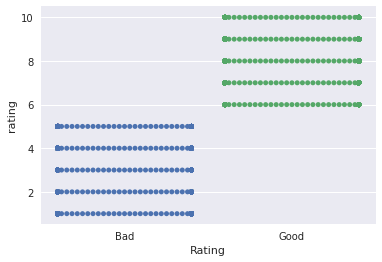

In [5]:
Data_df['Rating'] = pd.cut(Data_df['rating'], 2, labels = ['Bad', 'Good'])


sns.swarmplot(x="Rating", y="rating", data=Data_df)
plt.show()

# Drop unwanted columns


In [6]:
Data_df = Data_df[['Rating', 'commentsReview']]

Data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4132 entries, 0 to 1035
Data columns (total 2 columns):
Rating            4132 non-null category
commentsReview    4132 non-null object
dtypes: category(1), object(1)
memory usage: 228.7+ KB


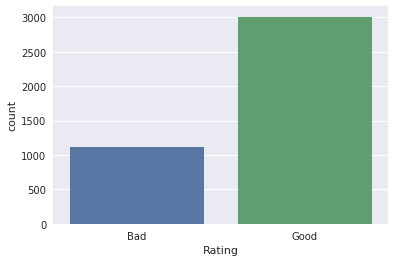

In [7]:
#Look at distribution
sns.countplot(x = 'Rating', data =Data_df)


In [45]:
print(Data_df['commentsReview'].str.split().str.len())

<bound method Series.max of 0        11
1        12
2        76
3        27
4         2
5         4
6       107
7         9
8       231
9         6
10       37
11       50
12       30
13       51
14       28
15       63
16       45
17        1
18       90
19       24
20       13
21       52
22       25
23       37
24       33
25        4
26       21
27       91
28        5
29       11
       ... 
1006     83
1007     71
1008    118
1009     40
1010     77
1011     63
1012     31
1013     56
1014      7
1015     72
1016    159
1017    140
1018     21
1019    101
1020     20
1021     37
1022      3
1023     70
1024     25
1025      9
1026     10
1027      8
1028      8
1029     20
1030     15
1031     39
1032     21
1033     43
1034     48
1035      7
Name: commentsReview, Length: 4132, dtype: int64>


## Create vector with features and vector with encoded label


In [46]:
X = Data_df.commentsReview
Y = Data_df.Rating
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

print(X.shape)
print(Y.shape)


(4132,)
(4132, 1)


## Train/test split

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4,  stratify=Y, random_state = 2018)

X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=2018)

## Preprocess the text data


In [48]:
max_words = 5000
max_len = 500
#Tokenize the data
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
#Convert to sequences
sequences = tok.texts_to_sequences(X_train)
#Ensure all sequences have same length
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)



## Set up model


In [60]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
embedding_vecor_length = 32

model = Sequential()
model.add(Embedding(max_words,embedding_vecor_length,input_length=max_len))
model.add(LSTM(100))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])




In [50]:
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 239,313
Trainable params: 239,313
Non-trainable params: 0
_________________________________________________________________


## Fit on dataset

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=3,
          validation_split=0.2)

# Adjust validation data en fit to data


In [58]:
val_sequences = tok.texts_to_sequences(X_val)
val_sequences_matrix = sequence.pad_sequences(val_sequences,maxlen=max_len)


accr = model.evaluate(val_sequences_matrix,Y_val)

496/496 [==============================] - 1s 3ms/step


In [59]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 4.339
  Accuracy: 0.728


# Fit on test data

In [39]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

prediction = model.predict(test_sequences_matrix)


In [42]:


target_names = ['Bad', 'Good']
print(confusion_matrix(Y_test, prediction))




[[ 449    0]
 [1204    0]]


### To do
* Test en train bij elkaar voegen en dan later splitsen
* LTSM model aanpassen